In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import scipy.io as sio
from PIL import Image
import seaborn as sns

In [2]:
# Definir rutas
TRAIN_PATH = r"C:\Users\Adrian\Downloads\trainSet"
TEST_PATH = r"C:\Users\Adrian\Downloads\testSet"

# Parámetros de redimensionamiento
# 512x288 mantiene mejor la relación con 1 DVA ≈ 38 píxeles
IMAGE_SIZE = (512, 288)

# Verificar que las rutas existen
assert os.path.exists(TRAIN_PATH), f"Train path does not exist: {TRAIN_PATH}"
assert os.path.exists(TEST_PATH), f"Test path does not exist: {TEST_PATH}"

In [3]:
def analyze_mat_structure(root_dir, num_categories=3, num_samples=1):
    """
    Analiza y muestra la estructura de los archivos .mat
    Args:
        root_dir: Directorio raíz del dataset
        num_categories: Número de categorías a analizar
        num_samples: Número de archivos .mat a analizar por categoría
    """
    fixloc_dir = os.path.join(root_dir, 'FIXATIONLOCS')
    categories = [d for d in os.listdir(fixloc_dir) 
                 if os.path.isdir(os.path.join(fixloc_dir, d))]
    
    print("Analizando estructura de archivos .mat...")
    print("-" * 50)
    
    # Tomar solo las primeras num_categories categorías
    for category in categories[:num_categories]:
        category_path = os.path.join(fixloc_dir, category)
        mat_files = [f for f in os.listdir(category_path) if f.endswith('.mat')]
        
        print(f"\nCategoría: {category}")
        
        # Analizar solo el primer archivo de cada categoría
        for mat_file in mat_files[:num_samples]:
            print(f"Archivo: {mat_file}")
            mat_path = os.path.join(category_path, mat_file)
            mat_data = sio.loadmat(mat_path)
            
            # Mostrar estructura
            print("Estructura del archivo:")
            for key in mat_data.keys():
                if not key.startswith('__'):  # Ignorar metadatos
                    print(f"- {key}: {type(mat_data[key])} "
                          f"Shape: {mat_data[key].shape}")
                    
                    # Mostrar valores de ejemplo
                    data = mat_data[key]
                    if data.size > 0:
                        print(f"  Primeros valores: {data.flatten()[:5]}")

# Analizar estructura de archivos .mat
analyze_mat_structure(TRAIN_PATH)

Analizando estructura de archivos .mat...
--------------------------------------------------

Categoría: Action
Archivo: 001.mat
Estructura del archivo:
- fixLocs: <class 'numpy.ndarray'> Shape: (1080, 1920)
  Primeros valores: [0 0 0 0 0]

Categoría: Affective
Archivo: 001.mat
Estructura del archivo:
- fixLocs: <class 'numpy.ndarray'> Shape: (1080, 1920)
  Primeros valores: [0 0 0 0 0]

Categoría: Art
Archivo: 001.mat
Estructura del archivo:
- fixLocs: <class 'numpy.ndarray'> Shape: (1080, 1920)
  Primeros valores: [0 0 0 0 0]


In [4]:
class EyeTrackingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directorio con las carpetas FIXATIONLOCS, FIXATIONMAPS, Stimuli
            transform (callable, optional): Transformaciones opcionales para las imágenes
            
        """
        self.root_dir = root_dir
        self.transform = transform
        
        # Obtener lista de todas las imágenes
        self.stimuli_dir = os.path.join(root_dir, 'Stimuli')
        self.fixmap_dir = os.path.join(root_dir, 'FIXATIONMAPS')
        self.fixloc_dir = os.path.join(root_dir, 'FIXATIONLOCS')
        
        # Obtener todas las categorías
        self.categories = [d for d in os.listdir(self.stimuli_dir) 
                         if os.path.isdir(os.path.join(self.stimuli_dir, d))]
        
        # Crear lista de todos los archivos
        self.image_paths = []
        for category in self.categories:
            category_path = os.path.join(self.stimuli_dir, category)
            for img_name in os.listdir(category_path):
                if img_name.endswith(('.jpg', '.png')):
                    self.image_paths.append((category, img_name))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        category, img_name = self.image_paths[idx]
        
        # Cargar imagen original
        img_path = os.path.join(self.stimuli_dir, category, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Cargar mapa de fijación
        fixmap_name = os.path.splitext(img_name)[0] + '.jpg'
        fixmap_path = os.path.join(self.fixmap_dir, category, fixmap_name)
        fixation_map = Image.open(fixmap_path).convert('L')
        
        # Cargar ubicaciones de fijación (.mat file)
        fixloc_name = os.path.splitext(img_name)[0] + '.mat'
        fixloc_path = os.path.join(self.fixloc_dir, category, fixloc_name)
        fixation_locs = sio.loadmat(fixloc_path)
        
        if self.transform:
            image = self.transform(image)
            fixation_map = self.transform(fixation_map)
        
        return {
            'image': image,
            'fixation_map': fixation_map,
            'fixation_locs': fixation_locs,
            'category': category
        }
    
# Definir transformaciones
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),  # Ahora usando 512x288
    transforms.ToTensor(),
])


In [5]:
def visualize_sample(dataset, idx):
    """
    Visualiza una muestra del dataset con su mapa de fijación
    """
    sample = dataset[idx]
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 8))  # Aumenté el tamaño
    
    # Imagen original
    if isinstance(sample['image'], torch.Tensor):
        img = sample['image'].permute(1, 2, 0)
        # Normalizar los valores a [0,1] si es necesario
        if img.max() > 1:
            img = img / 255.0
    else:
        img = sample['image']
    
    axes[0].imshow(img)
    axes[0].set_title(f'Original Image\nCategory: {sample["category"]}', fontsize=12)
    axes[0].axis('off')
    
    # Mapa de fijación
    if isinstance(sample['fixation_map'], torch.Tensor):
        fixmap = sample['fixation_map'].squeeze()
    else:
        fixmap = sample['fixation_map']
    
    # Usar una colormap diferente y ajustar la intensidad
    im = axes[1].imshow(fixmap, cmap='inferno', interpolation='gaussian')
    axes[1].set_title('Fixation Map', fontsize=12)
    axes[1].axis('off')
    
    # Agregar colorbar
    plt.colorbar(im, ax=axes[1])
    
    plt.tight_layout()
    plt.show()

In [6]:
def verify_image_loading(dataset, num_samples=1):
    """
    Verifica que las imágenes se estén cargando correctamente
    con las nuevas dimensiones
    """
    # Obtener las primeras 3 categorías
    first_three_categories = dataset.categories[:3]
    
    for category in first_three_categories:
        # Encontrar una imagen de esta categoría
        category_indices = [i for i, (cat, _) in enumerate(dataset.image_paths) 
                          if cat == category]
        if category_indices:
            idx = np.random.choice(category_indices)
            
            sample = dataset[idx]
            print(f"\nMuestra de categoría {category}:")
            print(f"Dimensiones de la imagen: {sample['image'].shape}")
            print(f"Dimensiones del mapa de fijación: {sample['fixation_map'].shape}")
            
            visualize_sample(dataset, idx)

# También podríamos ajustar las transformaciones para mantener mejor la proporción
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE, antialias=True),  # Asegurar antialiasing
    transforms.ToTensor(),
])

# Crear dataset y verificar
dataset = EyeTrackingDataset(
    root_dir=TRAIN_PATH,
    transform=transform
)

In [7]:
def analyze_original_resolutions(root_dir, num_samples=50):
    """
    Analiza las resoluciones originales de las imágenes
    para verificar la consistencia
    
    """
    stimuli_dir = os.path.join(root_dir, 'Stimuli')
    resolutions = []
    
    for category in os.listdir(stimuli_dir):
        category_path = os.path.join(stimuli_dir, category)
        if not os.path.isdir(category_path):
            continue
            
        files = [f for f in os.listdir(category_path) 
                if f.endswith(('.jpg', '.png'))]
        
        # Tomar muestras aleatorias de cada categoría
        samples = np.random.choice(files, 
                                 min(num_samples // len(os.listdir(stimuli_dir)), 
                                     len(files)), 
                                 replace=False)
        
        for img_file in samples:
            img_path = os.path.join(category_path, img_file)
            with Image.open(img_path) as img:
                resolutions.append(img.size)
    
    # Analizar resultados
    unique_resolutions = set(resolutions)
    print("\nResoluciones encontradas:")
    for res in unique_resolutions:
        count = resolutions.count(res)
        print(f"- {res}: {count} imágenes ({count/len(resolutions)*100:.1f}%)")

# Analizar resoluciones originales
analyze_original_resolutions(TRAIN_PATH)


Resoluciones encontradas:
- (1920, 1080): 40 imágenes (100.0%)


Total number of samples: 2000
Number of categories: 20
Categories: ['Action', 'Affective', 'Art', 'BlackWhite', 'Cartoon', 'Fractal', 'Indoor', 'Inverted', 'Jumbled', 'LineDrawing', 'LowResolution', 'Noisy', 'Object', 'OutdoorManMade', 'OutdoorNatural', 'Pattern', 'Random', 'Satelite', 'Sketch', 'Social']

Muestra de categoría Action:
Dimensiones de la imagen: torch.Size([3, 512, 288])
Dimensiones del mapa de fijación: torch.Size([1, 512, 288])


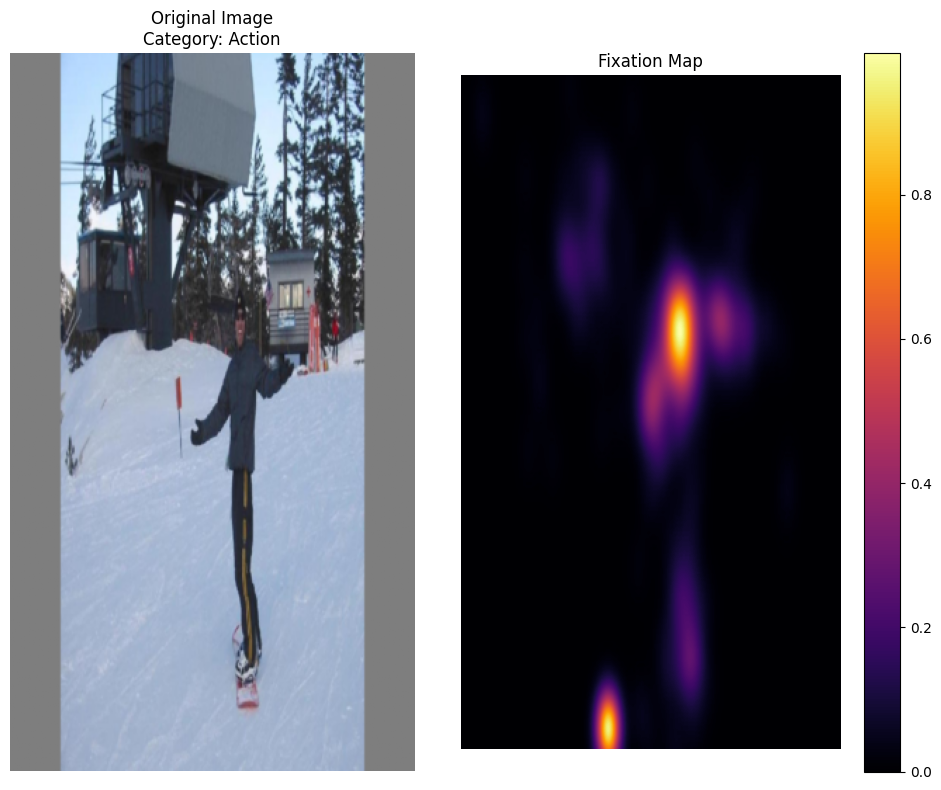


Muestra de categoría Affective:
Dimensiones de la imagen: torch.Size([3, 512, 288])
Dimensiones del mapa de fijación: torch.Size([1, 512, 288])


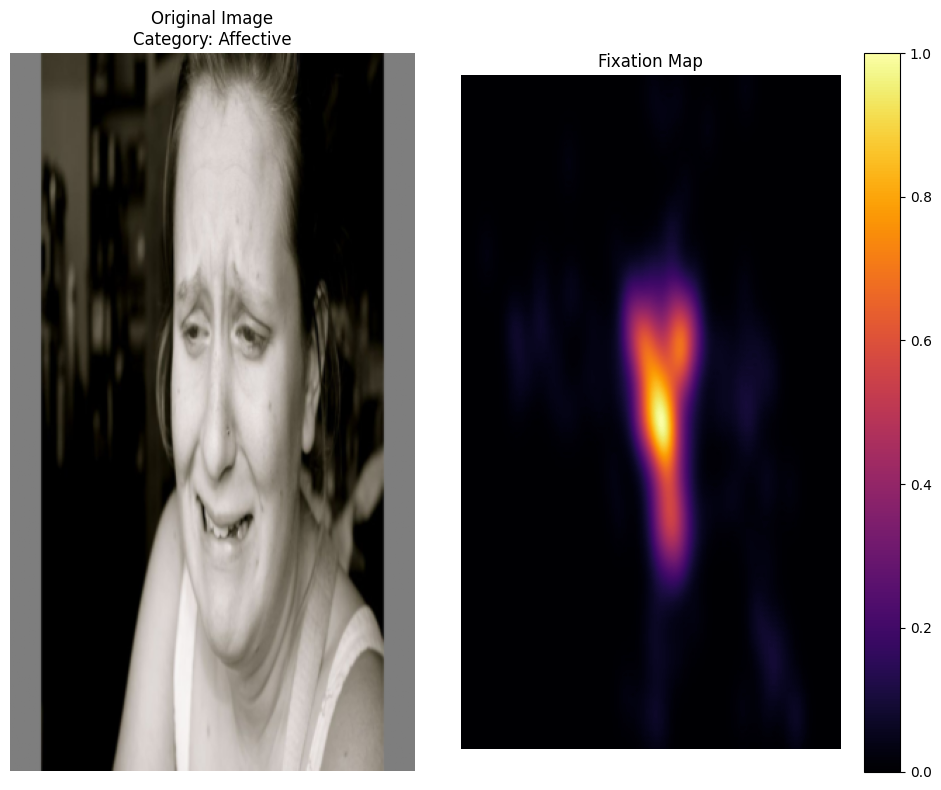


Muestra de categoría Art:
Dimensiones de la imagen: torch.Size([3, 512, 288])
Dimensiones del mapa de fijación: torch.Size([1, 512, 288])


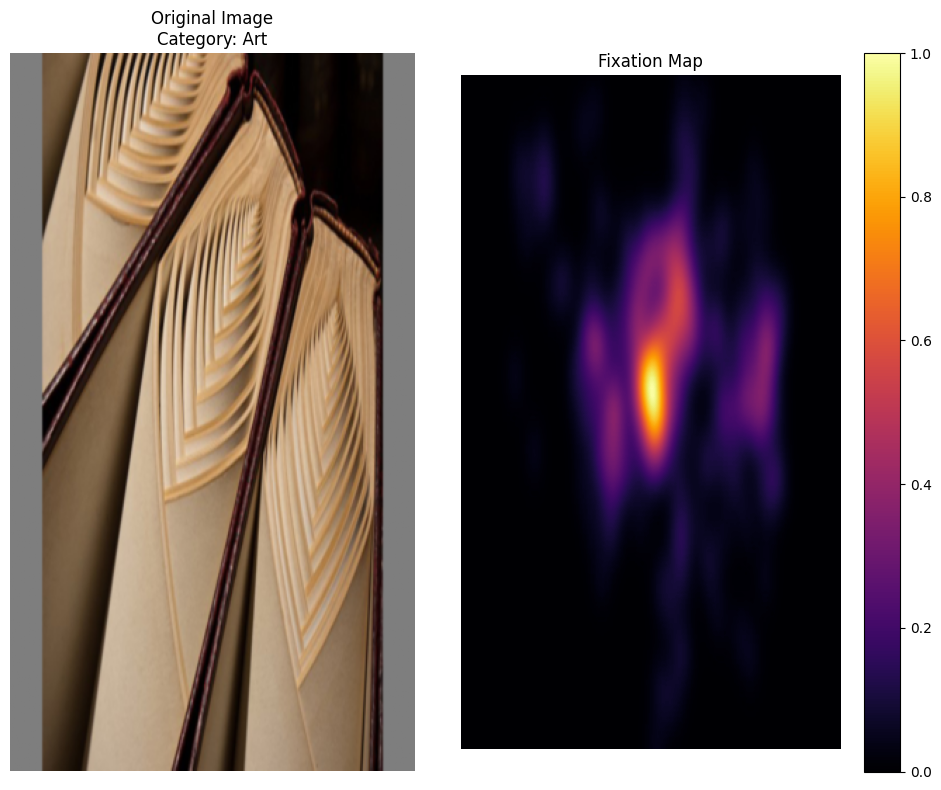

In [8]:
# Crear datasets
train_dataset = EyeTrackingDataset(
    root_dir=TRAIN_PATH,
    transform=transform
)

# Información básica
print(f"Total number of samples: {len(train_dataset)}")
print(f"Number of categories: {len(train_dataset.categories)}")
print(f"Categories: {train_dataset.categories}")

# Verificar carga y visualizar muestras
verify_image_loading(train_dataset)

# Analizar dataset
# analyze_dataset(train_dataset)

In [9]:
import torch.nn as nn
import torchvision.models as models

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        )
        
        self.conv = nn.Sequential(
            nn.Conv2d(out_channels*2, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = self.up(x)
        # Asegurar dimensiones compatibles para concatenación
        if x.shape != skip.shape:
            x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=True)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)


class SaliencyModel(nn.Module):
    def __init__(self):
        super(SaliencyModel, self).__init__()
        
        # Cargar ResNet50 preentrenado como encoder
        resnet = models.resnet50(pretrained=True)
        
        # Encoder layers
        self.encoder1 = nn.Sequential(resnet.conv1, resnet.bn1, resnet.relu)  # 64 channels
        self.pool = resnet.maxpool
        self.encoder2 = resnet.layer1  # 256 channels
        self.encoder3 = resnet.layer2  # 512 channels
        self.encoder4 = resnet.layer3  # 1024 channels
        self.encoder5 = resnet.layer4  # 2048 channels
        
        # Decoder layers con upsample para mantener dimensiones
        self.decoder1 = DecoderBlock(2048, 1024)
        self.decoder2 = DecoderBlock(1024, 512)
        self.decoder3 = DecoderBlock(512, 256)
        self.decoder4 = DecoderBlock(256, 64)
        
        # Capa adicional de upsampling para recuperar la resolución original
        self.final_upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        # Final output
        self.final = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        # Guardar dimensiones originales
        original_size = (x.shape[2], x.shape[3])
        
        # Encoder
        enc1 = self.encoder1(x)
        enc1_pool = self.pool(enc1)
        enc2 = self.encoder2(enc1_pool)
        enc3 = self.encoder3(enc2)
        enc4 = self.encoder4(enc3)
        enc5 = self.encoder5(enc4)
        
        # Decoder con skip connections
        dec1 = self.decoder1(enc5, enc4)
        dec2 = self.decoder2(dec1, enc3)
        dec3 = self.decoder3(dec2, enc2)
        dec4 = self.decoder4(dec3, enc1)
        
        # Upsampling final y convoluciones
        x = self.final_upsample(dec4)
        out = self.final(x)
        
        # Asegurar que la salida tenga las dimensiones correctas
        if out.shape[2:] != original_size:
            out = F.interpolate(out, size=original_size, mode='bilinear', align_corners=True)
        
        return out

In [10]:
# Crear modelo y mover a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SaliencyModel().to(device)

# Imprimir resumen del modelo
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Modelo creado en: {device}")
print(f"Número total de parámetros: {count_parameters(model):,}")

# Verificar si PyTorch detecta la GPU
if torch.cuda.is_available():
    print(f"PyTorch está usando la GPU: {torch.cuda.get_device_name(0)}")
else:
    print("PyTorch no detecta ninguna GPU.")

c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Adrian\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modelo creado en: cuda
Número total de parámetros: 85,729,089
PyTorch está usando la GPU: NVIDIA GeForce RTX 3070


In [11]:
def verify_model_dimensions():
    print("Verificando dimensiones del modelo...")
    model.eval()
    
    # Tomar una muestra del dataset directamente
    sample = train_dataset[0]
    images = sample['image'].unsqueeze(0).to(device)  # Agregar dimensión de batch
    
    # Imprimir dimensiones de entrada
    print(f"\nDimensiones de entrada:")
    print(f"Batch shape: {images.shape}")
    
    # Forward pass
    with torch.no_grad():
        output = model(images)
    
    # Imprimir dimensiones de salida
    print(f"\nDimensiones de salida:")
    print(f"Output shape: {output.shape}")
    print(f"Target shape: {sample['fixation_map'].unsqueeze(0).shape}")
    
    # Verificar que las dimensiones coincidan
    assert output.shape == sample['fixation_map'].unsqueeze(0).to(device).shape, \
        "¡Las dimensiones de salida no coinciden con las dimensiones objetivo!"
    
    print("\n✓ Las dimensiones del modelo son correctas")
    return True

In [12]:
class CheckpointSaver:
    def __init__(self, save_dir):
        self.save_dir = save_dir
        self.best_loss = float('inf')
        
        # Crear directorio si no existe
        os.makedirs(save_dir, exist_ok=True)
    
    def save_checkpoint(self, model, optimizer, epoch, loss, is_best=False):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
        }
        
        # Guardar último checkpoint
        torch.save(checkpoint, 
                  os.path.join(self.save_dir, 'last_checkpoint.pth'))
        
        # Guardar mejor modelo
        if is_best:
            torch.save(checkpoint, 
                      os.path.join(self.save_dir, 'best_model.pth'))
            print(f"✓ Mejor modelo guardado con loss: {loss:.4f}")
    
    def update(self, model, optimizer, epoch, loss):
        is_best = loss < self.best_loss
        if is_best:
            self.best_loss = loss
        self.save_checkpoint(model, optimizer, epoch, loss, is_best)

In [13]:
def visualize_predictions(model, dataset, num_samples=3):
    """
    Visualiza imágenes originales, mapas de fijación reales y predicciones
    """
    model.eval()
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    for i in range(num_samples):
        # Obtener muestra aleatoria
        idx = np.random.randint(len(dataset))
        sample = dataset[idx]
        
        # Obtener predicción
        with torch.no_grad():
            image = sample['image'].unsqueeze(0).to(device)
            pred = model(image)
            pred = torch.sigmoid(pred).squeeze().cpu()
        
        # Imagen original
        axes[i, 0].imshow(sample['image'].permute(1, 2, 0))
        axes[i, 0].set_title('Imagen Original')
        axes[i, 0].axis('off')
        
        # Mapa de fijación real
        axes[i, 1].imshow(sample['fixation_map'].squeeze(), cmap='inferno')
        axes[i, 1].set_title('Mapa Real')
        axes[i, 1].axis('off')
        
        # Predicción
        im = axes[i, 2].imshow(pred, cmap='inferno')
        axes[i, 2].set_title('Predicción')
        axes[i, 2].axis('off')
        
        # Agregar colorbar
        plt.colorbar(im, ax=axes[i, 2])
    
    plt.tight_layout()
    plt.show()

Iniciando verificación del modelo...

Verificando dimensiones del modelo...

Dimensiones de entrada:
Batch shape: torch.Size([1, 3, 512, 288])

Dimensiones de salida:
Output shape: torch.Size([1, 1, 512, 288])
Target shape: torch.Size([1, 1, 512, 288])

✓ Las dimensiones del modelo son correctas

Checkpoint saver configurado en: checkpoints

Generando visualizaciones de prueba...


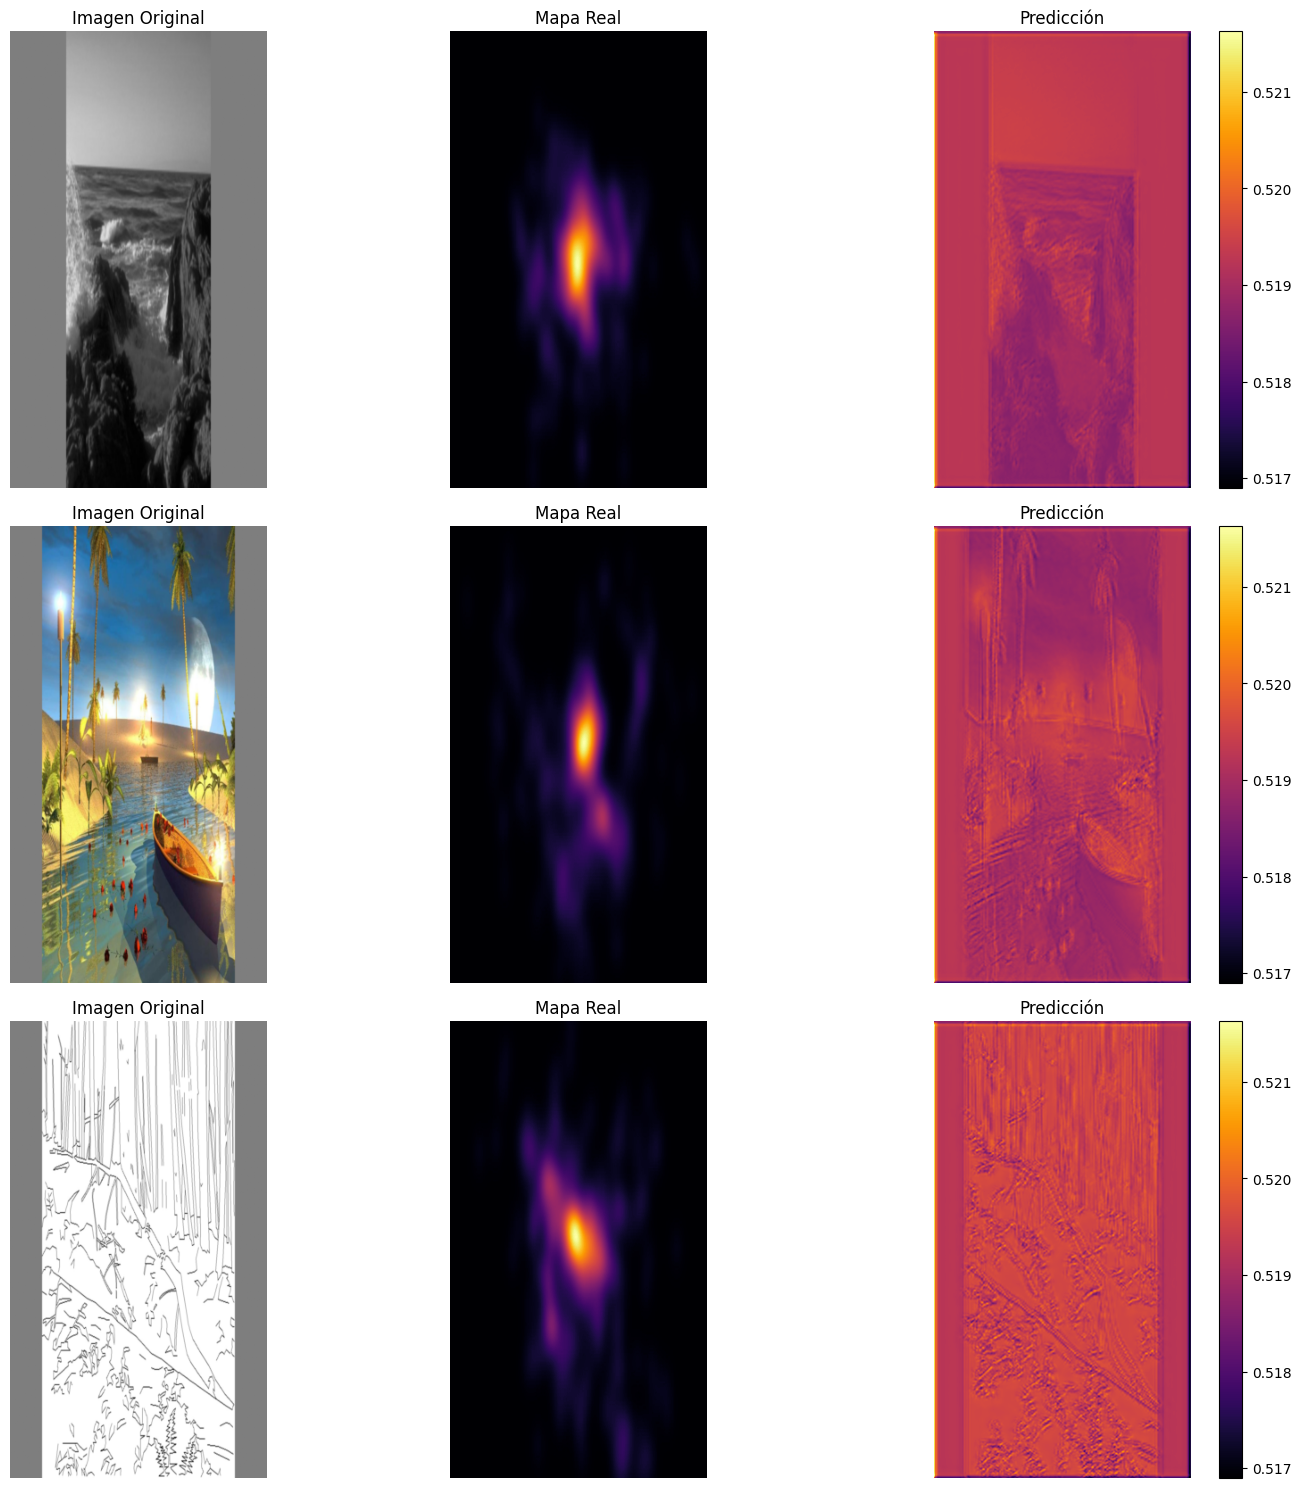

✓ Visualización de predicciones funciona correctamente

✓ ¡Configuración del modelo completada exitosamente!
Verificación completada exitosamente


In [14]:
def verify_model_setup():
    print("Iniciando verificación del modelo...\n")
    
    # 1. Verificar dimensiones
    try:
        verify_model_dimensions()
    except Exception as e:
        print(f"Error en verificación de dimensiones: {e}")
        return False, None  # Retornamos None como saver si hay error
    
    # 3. Configurar checkpoint saver
    checkpoint_dir = 'checkpoints'
    saver = CheckpointSaver(checkpoint_dir)
    print(f"\nCheckpoint saver configurado en: {checkpoint_dir}")
    
    # 4. Probar visualización de predicciones
    print("\nGenerando visualizaciones de prueba...")
    try:
        visualize_predictions(model, train_dataset)
        print("✓ Visualización de predicciones funciona correctamente")
    except Exception as e:
        print(f"Error en visualización: {e}")
        return False, None
    
    print("\n✓ ¡Configuración del modelo completada exitosamente!")
    return True, saver

# 3. Modificar cómo llamamos a la función
success, checkpoint_saver = verify_model_setup()
if not success:
    print("La verificación del modelo falló")
else:
    print("Verificación completada exitosamente")

In [15]:
# Hiperparámetros
learning_rate = 1e-4
batch_size = 8
num_epochs = 10

# Criterio de pérdida
criterion = nn.BCEWithLogitsLoss()

# Optimizador
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,  # Cambiamos a 0 para debuggear
    pin_memory=True if torch.cuda.is_available() else False
)

In [16]:
# Funciones de entrenamiento
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    
    # Barra de progreso
    from tqdm.notebook import tqdm
    progress_bar = tqdm(loader, desc='Training')
    
    for batch in progress_bar:
        images = batch['image'].to(device)
        targets = batch['fixation_map'].to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Actualizar métricas
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(loader)

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    
    # Barra de progreso
    from tqdm.notebook import tqdm
    progress_bar = tqdm(loader, desc='Validating')
    
    with torch.no_grad():
        for batch in progress_bar:
            images = batch['image'].to(device)
            targets = batch['fixation_map'].to(device)
            
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})
    
    return total_loss / len(loader)

In [17]:
def plot_training_progress(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Progress')
    plt.legend()
    plt.grid(True)
    plt.show()

In [26]:
from tqdm.notebook import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, checkpoint_saver):
    train_losses = []
    val_losses = []
    
    print("Iniciando entrenamiento...")
    
    # Barra de progreso para las épocas
    epoch_bar = tqdm(range(num_epochs), desc='Epochs', position=0)
    
    for epoch in epoch_bar:
        # Entrenamiento
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        
        # Validación
        val_loss = validate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        
        # Actualizar barra de progreso principal
        epoch_bar.set_postfix({
            'Train Loss': f'{train_loss:.4f}',
            'Val Loss': f'{val_loss:.4f}'
        })
        
        # Guardar checkpoint
        checkpoint_saver.update(model, optimizer, epoch, val_loss)
        
        # Visualizar progreso
        if (epoch + 1) % 5 == 0:  # cada 5 épocas
            plot_training_progress(train_losses, val_losses)
            visualize_predictions(model, train_dataset)
    
    return train_losses, val_losses

In [27]:
# Preparar datos de validación
from sklearn.model_selection import train_test_split

# Separar dataset en train y validación
train_indices, val_indices = train_test_split(
    range(len(train_dataset)),
    test_size=0.2,
    random_state=42
)

In [28]:
from torch.utils.data import Subset
train_data = Subset(train_dataset, train_indices)
val_data = Subset(train_dataset, val_indices)

# Crear dataloaders
train_loader = DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_data,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

In [25]:
# Iniciar entrenamiento
print("Configuración del entrenamiento:")
print(f"Device: {device}")
print(f"Batch size: {batch_size}")
print(f"Learning rate: {learning_rate}")
print(f"Epochs: {num_epochs}")
print(f"Train samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")

# Entrenar el modelo
train_losses, val_losses = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    num_epochs, 
    checkpoint_saver
)

# Visualizar resultados finales
plot_training_progress(train_losses, val_losses)

Configuración del entrenamiento:
Device: cuda
Batch size: 8
Learning rate: 0.0001
Epochs: 10
Train samples: 1600
Validation samples: 400
Iniciando entrenamiento...


Epochs:   0%|          | 0/10 [00:00<?, ?it/s]